In [50]:
import warnings
import numpy as np
import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Разделение датасета
from sklearn.model_selection import KFold, cross_val_score

# 3. Модели
from lightgbm import LGBMRegressor

%matplotlib inline

In [29]:
df = pd.read_csv('train.csv')
X_final = pd.read_csv('test.csv')
#df_submission = pd.read_csv('submission_new.csv')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [31]:
df_num_features = df.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022C0F1714F0>,
      dtype=object)

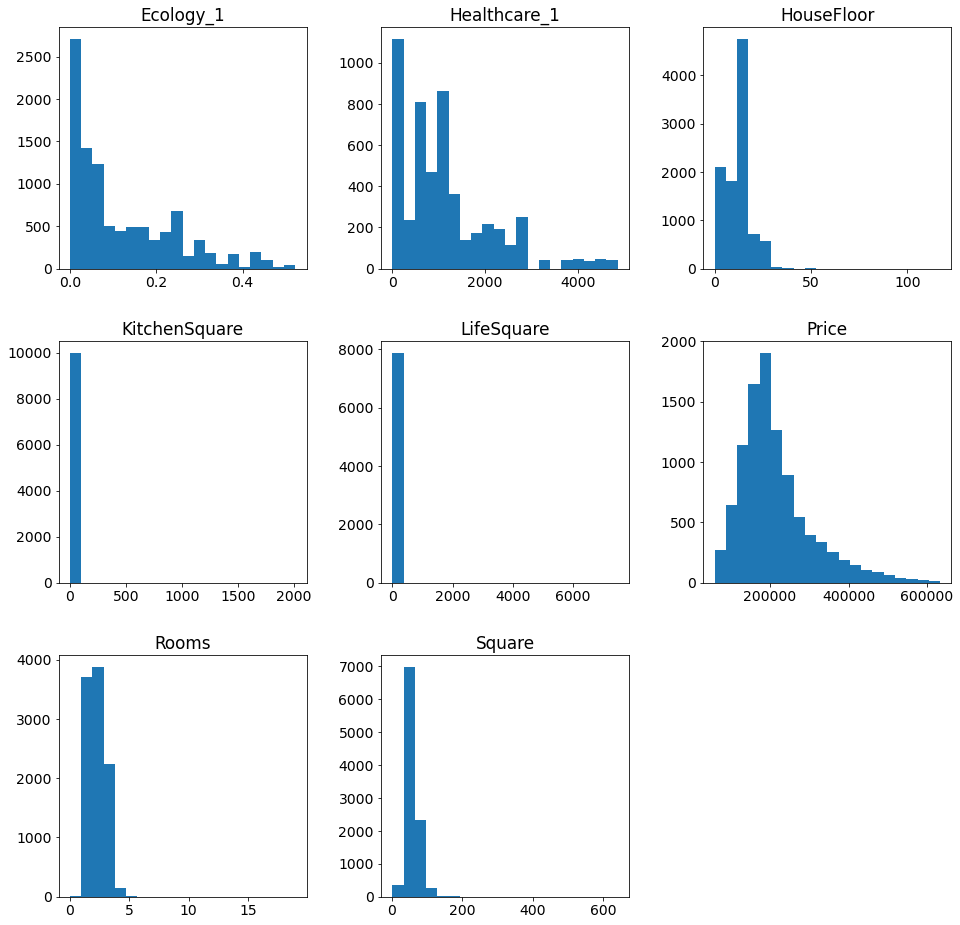

In [32]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False)

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [34]:
for feat in ['Rooms', 'KitchenSquare', 'HouseFloor']:
    print(f'Количество наблюдений, где {feat}=0: {df.loc[(df[feat] == 0)].shape[0]}')

Количество наблюдений, где Rooms=0: 8
Количество наблюдений, где KitchenSquare=0: 697
Количество наблюдений, где HouseFloor=0: 269


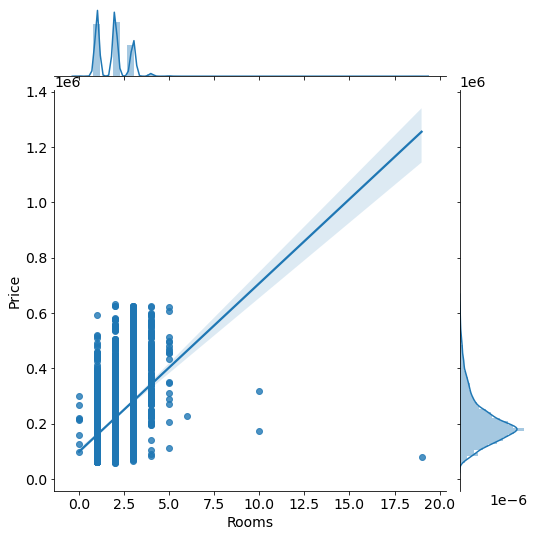

In [35]:
grid = sns.jointplot(df['Rooms'], df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

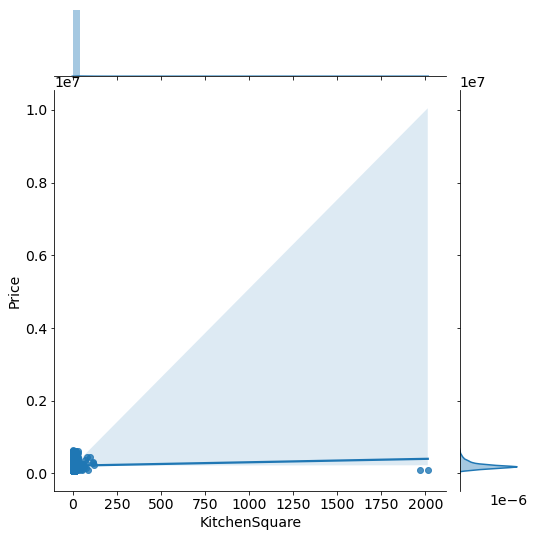

In [36]:
grid = sns.jointplot(df['KitchenSquare'], df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

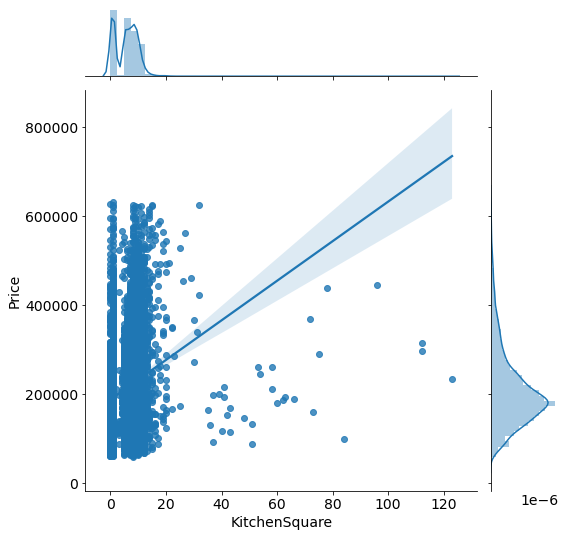

In [37]:
df_temp = df.loc[df['KitchenSquare']<250]
grid = sns.jointplot(df_temp['KitchenSquare'], df_temp['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

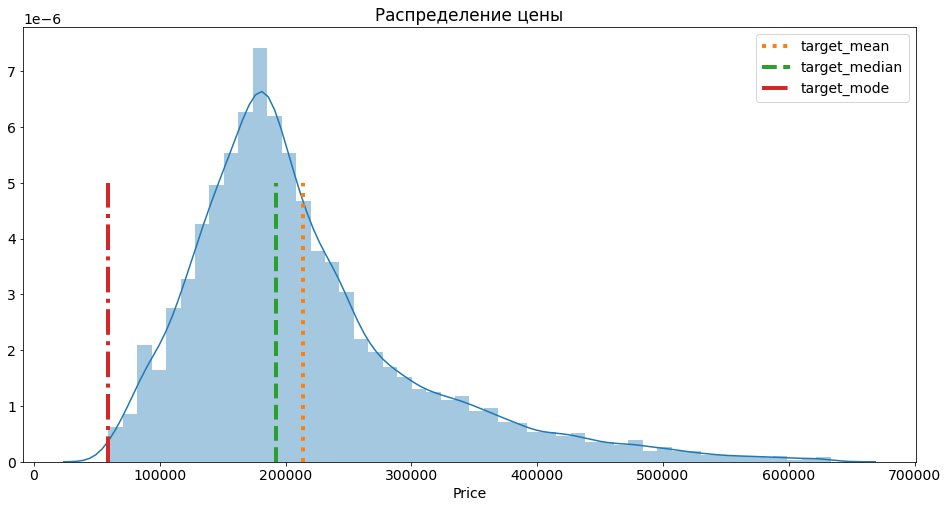

In [38]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='target_mean', linestyle=':',  linewidth=4)
plt.plot([target_median] * 10, y, label='target_median', linestyle='--',  linewidth=4)
plt.plot([target_mode] * 10, y, label='target_mode', linestyle='-.', linewidth=4)

plt.title('Распределение цены')
plt.legend()

In [39]:
class Data:
    
    def __init__(self):
        """Константы для обработки выбросов на основе анализа данных"""
        self.Square_min = 15
        self.Square_max = 300
        
        self.LifeSquare_min = 10
        self.LifeSquare_max = 280
        
        self.Rooms_min = 1
        self.Rooms_max = 5
        
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
        
        self.KitchenSquare_min = 3
        self.KitchenSquare_max = 30
        
        self.current_year = datetime.datetime.now().year
        
        self.medians = None
        self.DistrictId_value_counts = None
        self.SquareMeterPrice_by_DistrictId = None
        self.Healthcare_1_by_DistrictId = None
        
        
    def fit(self, df):
        
        # медианные значения
        self.medians = df[['LifeSquare', 'HouseFloor']].median()
        
        # подсчет популярных районов
        self.DistrictId_value_counts = dict(df['DistrictId'].value_counts())
        
        # подсчет средней цены за м2 по району
        df_temp = df.loc[((df['Square'] > self.Square_min) & (df['Square'] < self.Square_max))]
        df_temp["SquareMeterPrice"] = df_temp["Price"] / df_temp["Square"]
        self.SquareMeterPrice_by_DistrictId = df_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        
        # подсчет среднего значения признака Healthcare_1 по району
        self.Healthcare_1_by_DistrictId = df.groupby('DistrictId', as_index=False)\
            .agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})
        
        del df_temp
        
    def transform(self, df):
        
        # Обработка пропусков
        df[['LifeSquare', 'HouseFloor']] = df[['LifeSquare', 'HouseFloor']].fillna(self.medians)
        
        # Обработка выбросов
        
        # площадь
        df.loc[(df['Square'] > self.Square_max), 'Square'] = self.Square_max
        df.loc[(df['Square'] < self.Square_min), 'Square'] = self.Square_min
        
        # жилая площадь
        df.loc[(df['LifeSquare'] < self.LifeSquare_min), 'LifeSquare'] = self.LifeSquare_min
        df.loc[(df['LifeSquare'] > self.LifeSquare_max), 'LifeSquare'] = self.LifeSquare_max
        
        # площадь кухни
        df.loc[(df['KitchenSquare'] < self.KitchenSquare_min), 'KitchenSquare'] = self.KitchenSquare_min
        df.loc[(df['KitchenSquare'] > self.KitchenSquare_max), 'KitchenSquare'] = self.KitchenSquare_max
        
        # год постройки дома
        df.loc[(df['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year
        
        # количество комнат
        df.loc[(df['Rooms'] > self.Rooms_max), 'Rooms'] = self.Rooms_max
        df.loc[(df['Rooms'] < self.Rooms_min), 'Rooms'] = self.Rooms_min
        
        # количество этажей
        df.loc[(df['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        df.loc[(df['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        # если этаж больше этажности дома, то присваиваем случайный этаж от self.HouseFloor_min до максимального этажа в доме
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: self.HouseFloor_min if (self.HouseFloor_min == x) else np.random.randint(self.HouseFloor_min, x))
        
        # Обработка категорий
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        return df
    
    def features(self, df):
        
        # добавление признака популярности района
        df['DistrictId_counts'] = df['DistrictId'].map(self.DistrictId_value_counts)
        df['DistrictId_counts'].fillna(df['DistrictId_counts'].median(), inplace=True)
        
        # добавление признака средней стоимости м2 по району
        df = df.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        df['AverageSquareMeterPrice'].fillna(df['AverageSquareMeterPrice'].median(), inplace=True)
        
        # добавление признака среднего значения Healthcare_1 по району
        df = df.merge(self.Healthcare_1_by_DistrictId, on=["DistrictId"], how='left')
        df['AverageHealthcare_1'].fillna(df['AverageHealthcare_1'].median(), inplace=True)
        
        return df

In [40]:
data_inst = Data()

# тренировочные данные
data_inst.fit(df)
df = data_inst.transform(df)
df = data_inst.features(df)

# валидационные данные
X_final = data_inst.transform(X_final)
X_final = data_inst.features(X_final)

In [41]:
feature_names = ['AverageSquareMeterPrice', 'DistrictId_counts', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
                    'HouseFloor', 'HouseYear', 'Helthcare_2', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                    'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
                    'AverageHealthcare_1']
target_name = 'Price'

In [42]:
df = df[feature_names + [target_name]]
X_final = X_final[feature_names + ['Id']]

In [43]:
X = df[feature_names]
y = df[target_name]

In [52]:
%%time

final_model = LGBMRegressor(
    silent=True,
    learning_rate=0.1,
    iterations=1150,
    eval_metric='R2',
    depth=8
)

final_model.fit(X, y)

cv_score = cross_val_score(
    final_model,
    X,
    y,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

print(f'R2: {round(cv_score.mean(), 3)}')

R2: 0.76
Wall time: 648 ms


In [45]:
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X_final.set_index('Id', inplace=True)
X_final = X_final[feature_names]

In [46]:
y_pred_final = final_model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('./submission_new.csv', index=False, encoding='utf-8', sep=',')

preds_final.head()

,Id,Price
0,725,158071.133773
1,15856,215567.958083
2,5480,323487.800915
3,15664,322473.965603
4,14275,139903.160731


In [49]:
preds_final.shape

(5000, 2)